## Part 2: Uber Dataset

In [1]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.spatial import distance
from igraph import *
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import random
import math

### Q6

#### create graph

In [2]:
directory = os.path.abspath('/Users/bournsh/Desktop/UCLA_Studying/2020spring/ECE232/Project4/data')#
df = pd.read_csv(directory + '/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')

In [3]:
df.head()

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,17,296,10,1109.36,492.50,1021.90,1.48
1,28,186,10,1625.16,475.09,1565.73,1.30
2,758,972,12,953.55,269.46,916.93,1.33
3,1212,547,10,2053.39,648.63,1953.97,1.37
4,1299,1221,11,1467.54,539.64,1370.82,1.45


In [4]:
df = df.iloc[:, 0:4]
df = df.loc[df['month']==12]
dec_df = df.drop(['month'], axis=1)


In [5]:
dec_df.head()

,sourceid,dstid,mean_travel_time
2,758,972,953.55
5,1197,2006,1213.18
6,2652,620,828.92
7,2427,2693,1742.80
8,2653,610,699.03


In [6]:
init_dec_df = dec_df.copy()
init_dec_df['sourceid'] = init_dec_df['sourceid'].astype(str)
init_dec_df['dstid'] = init_dec_df['dstid'].astype(str)

In [7]:
tuples_init = [tuple(x) for x in init_dec_df.values]
g_init = Graph.TupleList(tuples_init, directed = False, edge_attrs = 'weight')

In [8]:
summary(g_init)

IGRAPH UNW- 2649 1692450 -- 
+ attr: name (v), weight (e)


#### clear the duplicates

In [9]:
dec_array = np.asarray(dec_df) 
existing_paths = {}
existing_locations = np.unique(np.concatenate([dec_array[:,0],dec_array[:,1]]))
counter = 0
for row in dec_array:
    locations = tuple(np.sort(row[0:2]))
    if locations in existing_paths:
        existing_paths[locations].append(row[2])
        counter += 1
    else:
        existing_paths[locations] = [row[2]]

with open(directory + '/december_data.txt','w') as f:
    for locations in existing_paths:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),np.mean(existing_paths[locations]))
        f.write(string)

In [10]:
g = Graph.Read(directory + '/december_data.txt', format='ncol', directed=False)
gcc = g.components().giant()
summary(g)
summary(gcc)

IGRAPH UNW- 2649 1004955 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 2649 1004955 -- 
+ attr: name (v), weight (e)


#### get the json file

In [11]:
with open(directory+'/los_angeles_censustracts.json', 'r') as f:
    data_json = json.load(f)
data_json.keys()

dict_keys(['type', 'features'])

In [12]:
geo_df = data_json['features']

In [13]:
colname = ['ID', 'Display_Name', 'Longitude', 'Latitude']
map_df = pd.DataFrame(columns = colname)
map_df

,ID,Display_Name,Longitude,Latitude


In [14]:
print(geo_df[0].keys())
print(geo_df[0]['properties'].keys())
print(geo_df[0]['geometry'].keys())

dict_keys(['type', 'properties', 'geometry'])
dict_keys(['MOVEMENT_ID', 'TRACT', 'DISPLAY_NAME'])
dict_keys(['type', 'coordinates'])


In [15]:
i = 1
for item in geo_df:
    map_df.loc[i, 'ID'] = item['properties']['MOVEMENT_ID']
    map_df.loc[i, 'Display_Name'] = item['properties']['DISPLAY_NAME']
    coors = item['geometry']['coordinates'][0][0]
    if isinstance(coors[0], list):
        longitude = 0
        latitude = 0

        for coor in coors:
            longitude = longitude+coor[0]
            latitude = latitude+coor[1]
            
        longitude = longitude/len(coors)
        latitude = latitude/len(coors)     
    else:
        coors = item['geometry']['coordinates'][0]
        longitude = 0
        latitude = 0

        for coor in coors:
            longitude = longitude+coor[0]
            latitude = latitude+coor[1]
            
        longitude = longitude/len(coors)
        latitude = latitude/len(coors)
#         longitude = coors[0]
#         latitude = coors[1]
        
    map_df.loc[i, 'Longitude'] = longitude
    map_df.loc[i, 'Latitude'] = latitude    
    i+=1

In [16]:
map_df

,ID,Display_Name,Longitude,Latitude
1,1,Census Tract 480302,-118.121,34.1031
2,2,Census Tract 480303,-118.138,34.0965
3,3,Census Tract 480304,-118.131,34.0963
4,4,Census Tract 480400,-118.132,34.1035
5,5,Census Tract 480500,-118.145,34.0987
...,...,...,...,...
2712,2712,Census Tract 087902,-117.988,33.792
2713,2713,Census Tract 110006,-118.078,33.7962
2714,2714,Census Tract 110007,-118.083,33.7881
2715,2715,Census Tract 110008,-118.08,33.781


#### map geo_coordinates with map information

In [17]:
gvs = g.vs()
for v in gvs:
    v["Display_Name"] = map_df.loc[map_df["ID"] == v['name']].iloc[:,1].values[0]
    v["Coordinate"] = (map_df.loc[map_df["ID"] == v['name']].iloc[:,2].values[0],
                       map_df.loc[map_df["ID"] == v['name']].iloc[:,3].values[0])
gcc = g.components().giant()                    

In [18]:
summary(g)
summary(gcc)


IGRAPH UNW- 2649 1004955 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)
IGRAPH UNW- 2649 1004955 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)


### Q7

In [19]:
mst = gcc.spanning_tree(weights = gcc.es['weight'])
vertices = mst.vs()
summary(mst)

IGRAPH UNW- 2649 2648 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)


In [20]:
# for i in range(6):
#     r = random.randint(0, len(vertices))
#     print("Random point{}:".format(i+1))
#     print("One endpoint:\nID: {}, Display_Name: {}".format(vertices[r]["name"], vertices[r]["Display_Name"]))
# #    print("Coordinate: {}".format(vertices[r]["Coordinate"]))
#     print("Another endpoint:\nID: {}, Display_Name: {}".format(vertices[r+1]["name"], vertices[r+1]["Display_Name"]))
#     print('='*60)
#    print("Coordinate: {}\n".format(vertices[r+1]["Coordinate"]))

## Define the project

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import *

In [22]:
os.environ['PROJ_LIB'] = r'/Users/bournsh/opt/anaconda3/share/proj/'
from mpl_toolkits.basemap import Basemap

In [23]:
def get_flow(dist, time):
    speed = dist/time
    flow = 2/(0.003/speed + 1/1800)
    return flow
def get_edge_flow(g):
    g_Es = EdgeSeq(g)
    for es in g_Es:
        vertex1 = es.tuple[0]
        vertex2 = es.tuple[1]
        coor_1 = gcc.vs[vertex1]['Coordinate']
        coor_2 = gcc.vs[vertex2]['Coordinate']
        dist = 69*distance.euclidean(coor_1, coor_2)
        time = es['weight']/3600
        if dist==0:
            continue
        flow = get_flow(dist, time)
        es['Flow'] = flow
    return g

In [24]:
gcc_flow = get_edge_flow(gcc)
gcc_flow.summary()

'IGRAPH UNW- 2649 1004955 -- \n+ attr: Coordinate (v), Display_Name (v), name (v), Flow (e), weight (e)'

In [46]:
df_2 = pd.read_csv(directory+'/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
df_2

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,17,296,10,1109.36,492.50,1021.90,1.48
1,28,186,10,1625.16,475.09,1565.73,1.30
2,758,972,12,953.55,269.46,916.93,1.33
3,1212,547,10,2053.39,648.63,1953.97,1.37
4,1299,1221,11,1467.54,539.64,1370.82,1.45
...,...,...,...,...,...,...,...
5144057,1116,953,12,1336.86,654.73,1237.13,1.43
5144058,1732,1170,10,1913.06,645.32,1820.24,1.36
5144059,1167,443,12,1467.28,541.92,1380.16,1.41
5144060,352,1086,10,1306.80,390.56,1252.47,1.34


In [47]:
df_2 = df_2.iloc[:, 0:3]
df_2

,sourceid,dstid,month
0,17,296,10
1,28,186,10
2,758,972,12
3,1212,547,10
4,1299,1221,11
...,...,...,...
5144057,1116,953,12
5144058,1732,1170,10
5144059,1167,443,12
5144060,352,1086,10


In [43]:
len(df_2.loc[df_2['month']]==12)

5144062

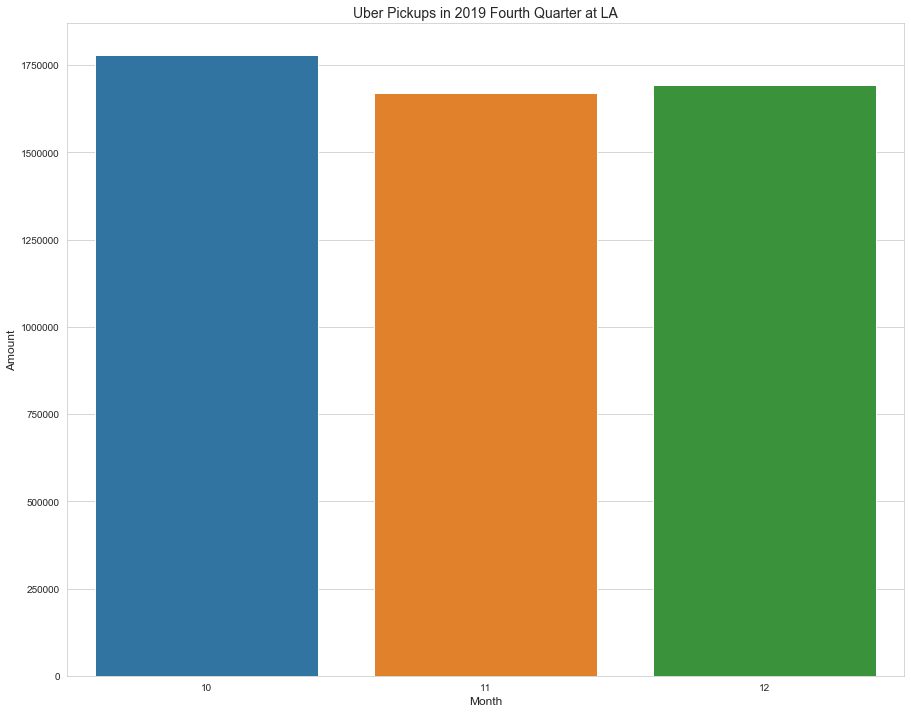

In [55]:
import seaborn as sns
sns.set_style('whitegrid')
ax = sns.countplot(x = 'month', data = df_2)
ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Amount', fontsize = 12)
ax.set_title('Uber Pickups in 2019 Fourth Quarter at LA', fontsize = 14)
plt.style.use({'figure.figsize':(15, 12)})
plt.show()

/Users/bournsh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


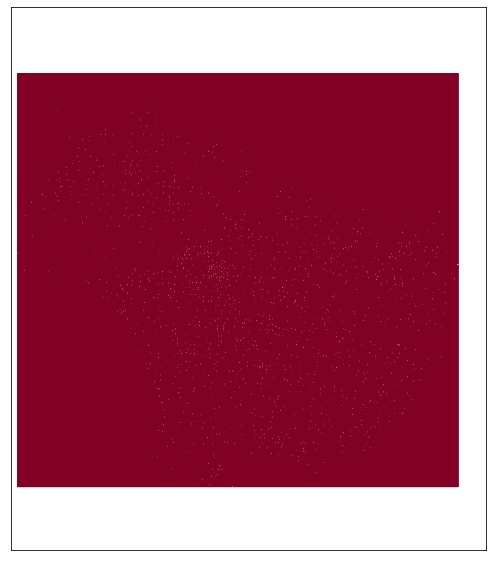

In [26]:
west, south, east, north = -118.70, 33.60, -117.75, 34.50
fig = plt.figure(figsize = (14, 10))
hm = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='h')
x, y = hm(map_df['Longitude'].values, map_df['Latitude'].values)
hm.hexbin(x, y, gridsize = 1000, bins = 'log', cmap = cm.YlOrRd_r)
